Licensed under the MIT License.

# Activity2Vec: Learning ADL Embeddings from Sensor Data with a Sequence-to-Sequence Model

This notebook provides an example of how to train an Act2Vec model to extract features. We will train an Act2Vec based model on the describe in the paper refrence blow.

In this notebook, we will train an Act2Vec model on UCI-HAR data, and then employ a random forest as our classifier.

Reference: https://arxiv.org/abs/1907.05597

In [1]:
# Import packages
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import tensorflow as tf
import numpy as np
from datasets.har import load_data
from model.act2vec import Act2Vec
from util.utils import plot_latent_space
from util.utils import rf
from util.utils import plot_confusion_matrix
from util.utils import print_result

In [2]:
# allow tenserflow to use GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
os.environ['AUTOGRAPH_VERBOSITY'] = '10'
tf.autograph.set_verbosity(0)

## UCI-HAR dataset

Let's start with downloading dataset, and load the datasets. 

In [3]:
(x_train, y_train), (x_test, y_test) = load_data()

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.



In [4]:
print('x_train shape is: ', x_train.shape)
print('x_test shape is: ', x_test.shape)
print('Number of classes: ', len(np.unique(y_train)))

x_train shape is:  (7352, 128, 9)
x_test shape is:  (2947, 128, 9)
Number of classes:  6


## Encode the data by employing Act2Vec model

### Building an Act2Vec Model

In [5]:
act2vec = Act2Vec(units=128, input_dim=x_train.shape)
opt = tf.keras.optimizers.Adam(lr=2e-5, decay=2e-11)
act2vec.compile(loss='mse',
             optimizer=opt,
             metrics=['mse'])

In [6]:
# train the act2vec moedl
act2vec.fit(x_train,x_train,
         batch_size=32,
         epochs=4000)
act2vec.save_weights('HAR-act2vec_model.h5')

Train on 7352 samples
Epoch 1/4000
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.1036 - mse: 0.1036
Epoch 2/4000
7352/7352 [==============================] - 6s 795us/sample - loss: 0.0604 - mse: 0.0604
Epoch 3/4000
7352/7352 [==============================] - 6s 804us/sample - loss: 0.0572 - mse: 0.0572
Epoch 4/4000
7352/7352 [==============================] - 4s 487us/sample - loss: 0.0562 - mse: 0.0562
Epoch 5/4000
7352/7352 [==============================] - 3s 453us/sample - loss: 0.0557 - mse: 0.0557
Epoch 6/4000
7352/7352 [==============================] - 3s 447us/sample - loss: 0.0555 - mse: 0.0555
Epoch 7/4000
7352/7352 [==============================] - 3s 451us/sample - loss: 0.0552 - mse: 0.0552
Epoch 8/4000
7352/7352 [==============================] - 4s 610us/sample - loss: 0.0551 - mse: 0.0551
Epoch 9/4000
7352/7352 [==============================] - 5s 727us/sample - loss: 0.0549 - mse: 0.0549
Epoch 10/4000
7352/7352 [===========================

### After taining the act2vec model, we can use it to extract fetures

In [7]:
X_train = act2vec.encoder(x_train)
X_test = act2vec.encoder(x_test)

In [8]:
print('Encoded X_train shape is: ', X_train.shape)
print('Encoded X_test shape is: ', X_test.shape)

Encoded X_train shape is:  (7352, 256)
Encoded X_test shape is:  (2947, 256)


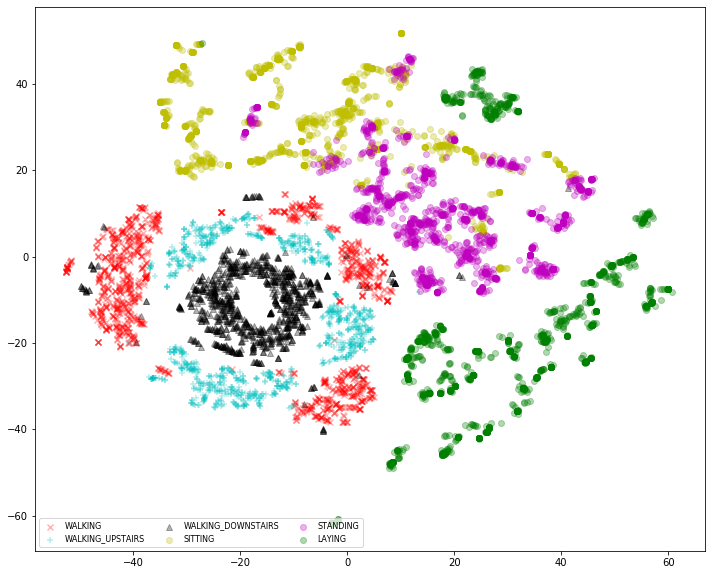

In [9]:
plot_latent_space(X_train, y_train, 'UCI_HAR_Xtrain_latentspace')

### Train random forest on encoded data

In [10]:
random_forest_en = rf(X_train, y_train, n_estimators=100) 

In [11]:
print_result(random_forest_en, X_train, y_train, X_test, y_test)

Train accuracy:  1.0
Test accuracy:  0.9182219205972175


Normalized confusion matrix


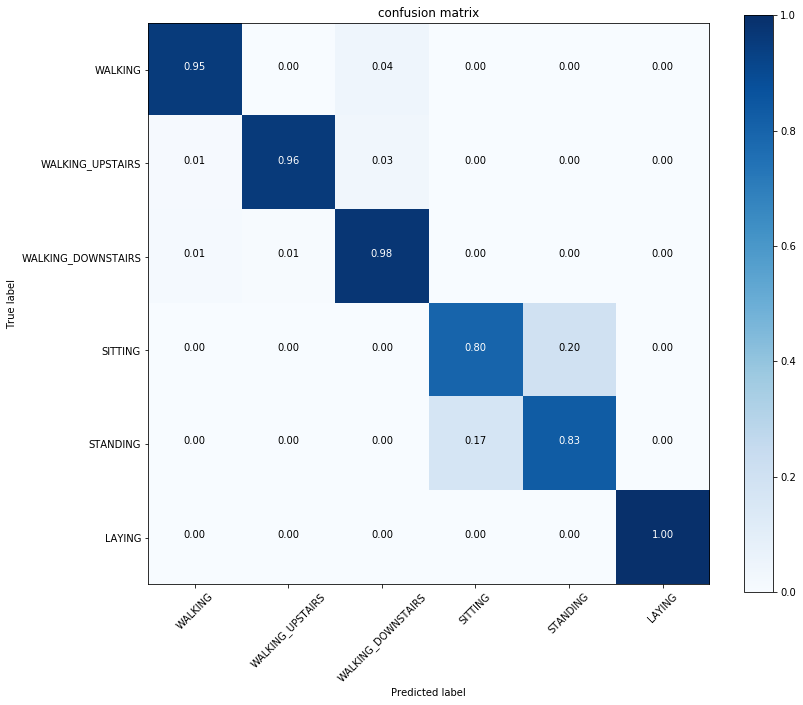

In [12]:
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
plot_confusion_matrix(random_forest_en, X_test, y_test, class_names=LABELS, file_name='HAR_confusionmatrix_en', normalize=True)

### Train random forest on raw data

In [13]:
random_forest_raw = rf(x_train.reshape(X_train.shape[0], np.prod(x_train.shape[1:])), y_train, n_estimators=100) 

In [14]:
print_result(random_forest_raw, x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:])), y_train, x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:])), y_test)

Train accuracy:  1.0
Test accuracy:  0.8469630132337971


Normalized confusion matrix


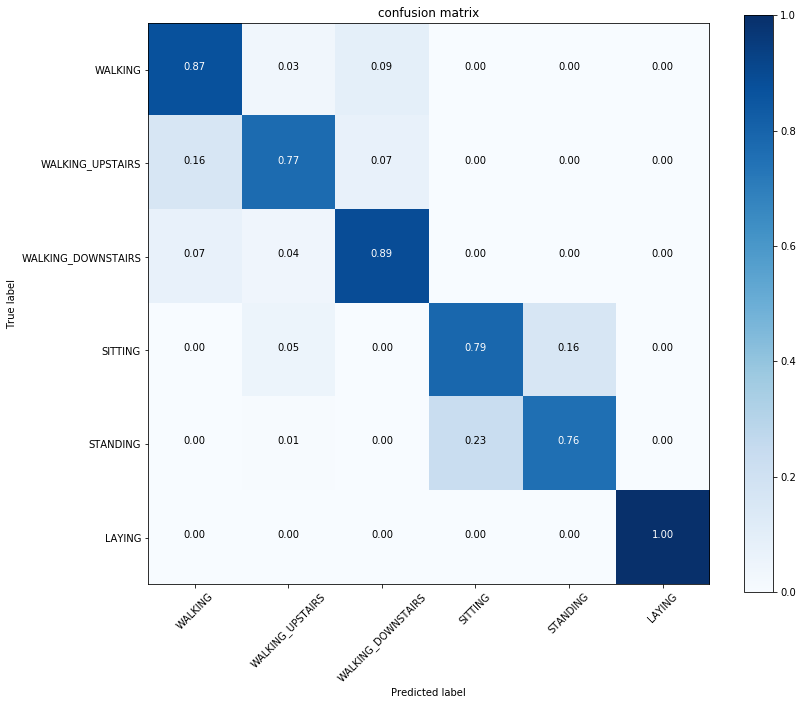

In [15]:
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
plot_confusion_matrix(random_forest_raw, x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:])), y_test, class_names=LABELS, file_name='HAR_confusionmatrix_raw', normalize=True)